In [1]:
!rm -rf ./metastore_db/
#pyspark --executor-memory 8g --driver-memory 8g --conf spark.driver.maxResultSize=2g

In [2]:
import numpy as np
import json
import pickle
import shutil
import seaborn as sns
from time import mktime
from datetime import datetime
from pyspark.ml.feature import StringIndexer, StandardScaler, IndexToString
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction, stddev
from pyspark.sql.functions import * # array, desc, asc, mean
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, DateType, IntegerType
%matplotlib inline

sqlc = SQLContext(sc)

In [3]:
class YelpRecommender(object):
    def __init__(self, folder='./', business_filename=None, reviews_filename=None):
        self._folder = folder
        if business_filename is None:
            business_filename = os.path.join(folder, 'yelp_academic_dataset_business.json')
        if reviews_filename is None:
            reviews_filename = os.path.join(folder, 'yelp_academic_dataset_review.json')
        
        self._city = None
        self._category = None
        self._min_per_user = 0
        self._scaler = {'mean': True, 'stdev': False}
        
        self._verbose = True
        self._business = None
        self._reviews = None
        self._city_business = None
        self._city_reviews = None
        self._dataset = None
        self._training = None
        self._test = None
        self._best_model = None
        self._best_parms = None
        self._eval = None
        
        self._business_dict = {}
        self._user_dict = {}
        self._review_dict = {}
        
        self.load_business(business_filename)
        self.load_reviews(reviews_filename)
    
    def console(self, message):
        if self._verbose:
            print(message)
            
    @property
    def best_model(self):
        return self._best_model
    
    @property
    def best_parms(self):
        return self._best_parms
    
    @property
    def evaluation(self):
        return self._eval
    
    @property
    def all_users(self):
        return self._user_dict.keys()
    
    @staticmethod
    def rest_to_json(row):
        return {row.business_idn: {'name': row.name,
                                   'address': row.address, 
                                   'stars': row.stars, 
                                   'categories': row.categories}}
    
    def load_business(self, filename):
        self.console('Loading businesses data...')
        if os.path.exists('./metastore_db/dbex.lck'):
            os.remove('./metastore_db/dbex.lck')    
        business = sqlc.read.json(filename)
        business = business.select('business_id', 'name', 'city', 'stars', 'categories', 'address')
        self._business = business

    def load_reviews(self, filename):
        self.console('Loading reviews data...')
        if os.path.exists('./metastore_db/dbex.lck'):
            os.remove('./metastore_db/dbex.lck')    
        reviews = sqlc.read.json(filename)
        reviews = reviews.select('user_id', 'business_id', 'stars', 'date')
        self._reviews = reviews

    def _get_city_businesses(self, category):
        def is_category_listed(name, categories):
            listed = 0.0
            if categories is not None:
                if name in categories:
                    listed = 1.0
            return listed
        
        is_category = UserDefinedFunction(lambda c: is_category_listed(category, c), DoubleType())

        business_cat = self._business.withColumn('is_category', is_category('categories')) \
                                    .filter('is_category = 1.0') \
                                    .drop('is_category')

        city_business = business_cat.filter('city = "' + self._city +'"')

        business_indexer = StringIndexer().setInputCol('business_id').setOutputCol('business_idn')
        business_idx_model = business_indexer.fit(city_business)
        city_business = business_idx_model.transform(city_business)

        city_business.cache()

        rest = city_business.select('business_idn', 'name', 'address', 'stars', 'categories').rdd.collect()
        rest = map(self.rest_to_json, rest)
        rest = {k: v for d in rest for k, v in d.items()}

        filename = os.path.join(folder, '%s_%s_business.pickle' % (self._city.replace(' ', '_'), self._category))
        self.console('Saving business data to %s ...' % filename)
        with open(filename, 'wb') as f:
            pickle.dump(rest, f)
        self._business_dict = rest

        self._city_business = city_business

    def _get_city_reviews(self):
        reviews_city = self._reviews.join(self._city_business.select('business_id', 'business_idn'), on='business_id')

        np.random.seed(42)
        to_timestamp = UserDefinedFunction(lambda d: mktime(datetime.strptime(d, '%Y-%m-%d').timetuple()) + np.random.random(), DoubleType())
        df_selected = reviews_city.select('user_id', 'business_idn', 'stars', to_timestamp('date').alias('timestamp')).drop('date')

        if self._min_per_user > 0:
            df_selected.createOrReplaceTempView('ratings')
            df_selected = sqlc.sql('select user_id, business_idn, stars, timestamp \
                                    from ratings \
                                    where user_id in (select user_id \
                                                      from ratings \
                                                      group by user_id \
                                                      having count(1) > ' + str(self._min_per_user) + ')')

        df_selected.cache()
        user_indexer = StringIndexer().setInputCol('user_id').setOutputCol('user_idn')
        user_idx_model = user_indexer.fit(df_selected)
        df_selected = user_idx_model.transform(df_selected)    

        df_selected.cache()
        user_last = df_selected.select('user_id', 'timestamp').groupby('user_id').max().rdd.collectAsMap()
        user_last_lookup = sc.broadcast(user_last)    

        get_last = UserDefinedFunction(lambda c: user_last_lookup.value.get(c), DoubleType())
        df_selected = df_selected.withColumn('last_time', get_last('user_id'))
        df_selected.cache()

        user_mapping = df_selected.select('user_id', 'user_idn').groupby('user_id').max().rdd.collectAsMap()
        filename = os.path.join(folder, '%s_%s_user.pickle' % (self._city.replace(' ', '_'), self._category))
        self.console('Saving user data to %s ...' % filename)
        with open(filename, 'wb') as f:
            pickle.dump(user_mapping, f)
        self._user_dict = user_mapping

        all_visited = df_selected.select('user_idn', 'business_idn').groupby('user_idn').agg(collect_list('business_idn')).rdd.collectAsMap()
        filename = os.path.join(folder, '%s_%s_review.pickle' % (self._city.replace(' ', '_'), self._category))
        self.console('Saving review data to %s ...' % filename)
        with open(filename, 'wb') as f:
            pickle.dump(all_visited, f)
        self._review_dict = all_visited

        self._city_reviews = df_selected

    def _apply_scaler(self, mean=True, stdev=False):
        if mean:
            user_means = self._city_reviews.select('user_id', 'stars').groupby('user_id').mean().rdd.collectAsMap()
        else:
            user_means = {}

        user_means_lookup = sc.broadcast(user_means)

        if stdev:
            user_stds = self._city_reviews.select('user_id', 'stars').groupby('user_id').agg(stddev('stars').alias('stddev')).rdd.collect()
            user_stds = dict(map(lambda row: (row.user_id, row.stddev if row.stddev > 0.0 else 1.0), user_stds))
        else:
            user_stds = {}
        user_stds_lookup = sc.broadcast(user_stds)    

        center_user_stars = UserDefinedFunction(lambda cols: (float(cols[1]) - user_means_lookup.value.get(cols[0], 0.0))/user_stds_lookup.value.get(cols[0], 1.0), DoubleType())

        df_scaled = self._city_reviews.withColumn('centered', center_user_stars(array('user_id','stars'))) \
                        .drop('stars') \
                        .withColumnRenamed('centered', 'stars')

        df_scaled.cache()

        self._dataset = df_scaled

    def _training_test_split(self):
        training = self._dataset.filter('last_time <> timestamp')
        test = self._dataset.filter('last_time = timestamp')
        
        # https://github.com/apache/spark/pull/12896
        available_business = sc.broadcast(set(training.select('business_idn').distinct().rdd.map(lambda t: t.business_idn).collect()))
        is_available = UserDefinedFunction(lambda idn: 1.0 if idn in available_business.value else 0.0, DoubleType())    
        test = test.withColumn('available', is_available('business_idn'))
        test = test.filter('available = 1.0')

        self._training, self._test = training, test

    def _grid_search(self, paramGrid):
        model_list = []
        eval_lists = {'train_rmse': [], 'test_rmse': []}

        param_list = [dict(map(lambda t: (t[0].name, t[1]), params.items())) for params in paramGrid]

        for idx, params in enumerate(param_list):
            self.console("Training model %d/%d with %s" % (idx + 1, len(param_list), params))
            model = ALS(userCol="user_idn", itemCol="business_idn", ratingCol="stars", seed=42).setParams(**params)
            model = model.fit(self._training)
            model_list.append(model)

            predictions = model.transform(self._training)
            evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars",
                                            predictionCol="prediction")
            train_rmse = evaluator.evaluate(predictions)
            eval_lists['train_rmse'].append(train_rmse)
            self.console("Train Root-mean-square error = " + str(train_rmse))

            predictions = model.transform(self._test)
            evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars",
                                            predictionCol="prediction")
            test_rmse = evaluator.evaluate(predictions)
            eval_lists['test_rmse'].append(test_rmse)
            self.console("Test Root-mean-square error = " + str(test_rmse))

        best_seq = np.argmin(eval_lists['test_rmse'])
        best_model = model_list[best_seq]
        best_parms = param_list[best_seq]
        
        self._best_model, self._best_parms, self._eval = best_model, best_parms, eval_lists
        
        model_filename = os.path.join(folder, '%s_als_model_regParm%0.1f_rank%d_maxIter%d' % (self._city.replace(' ', '_'), best_parms['regParam'], best_parms['rank'], best_parms['maxIter']))
        self.console("Best model parameters: %s" % best_parms)
        self.console("Saving best model to %s" % model_filename)
        if os.path.exists(model_filename):
            shutil.rmtree(model_filename)
        best_model.save(model_filename)
    
    def fit(self, city, category, parms, verbose=True):
        self._verbose = verbose
        
        self._city = city
        self._category = category
        self._min_per_user = parms['min_per_user']
        self._scaler = parms['scaler']
        
        self.console('Filtering businesses for the city...')
        self._get_city_businesses(self._category)
        self.console('Filtering reviews for the city...')
        self._get_city_reviews()
        self.console('Scaling user ratings...')
        self._apply_scaler(mean=self._scaler['mean'], stdev=self._scaler['stdev'])
        self.console('Splitting dataset into training and test...')
        self._training_test_split()

        als = ALS()
        paramGrid = ParamGridBuilder() \
            .addGrid(als.rank, parms['als']['rank']) \
            .addGrid(als.maxIter, parms['als']['maxIter']) \
            .addGrid(als.regParam, parms['als']['regParam']) \
            .build()

        self.console('Performing grid search over parameters...')
        self._grid_search(paramGrid)
        self.console('Finished!')
        
    def recommend(self, user_id, n):
        n_business = len(self._business_dict)
        user_idn = self._user_dict[user_id]
        visited = self._review_dict[user_idn]
        test_user = sqlc.createDataFrame([Row(user_idn=user_idn, business_idn=float(i)) for i in list(set(range(n_business)).difference(set(visited)))])

        pred_test = self._best_model.transform(test_user).na.fill(-5.0)
        top_pred = pred_test.orderBy(desc('prediction')).select('business_idn').rdd.map(lambda row: row.business_idn).take(n)
        response = map(lambda idn: self._business_dict[idn], top_pred)
        return json.dumps(response)
    
    def list_ratings(self, user_id, n):
        user_idn = self._user_dict[user_id]
        visited = self._review_dict[user_idn]
        response = sorted(map(lambda idn: self._business_dict[idn], visited), key=lambda k: k['stars'], reverse=True)[:n]
        return json.dumps(response)

In [4]:
folder = './dataset'

rec = YelpRecommender(folder)

Loading businesses data...
Loading reviews data...


In [5]:
parms = {'min_per_user': 4,
         'scaler': {'mean': True, 'stdev': False},
         'als': {'rank': [5, 10, 20],
                 'maxIter': [5, 10],
                 'regParam': [1.0, 0.3, 0.1]}}

rec.fit('Edinburgh', 'Restaurants', parms)

Filtering businesses for the city...
Saving business data to ./dataset/Edinburgh_Restaurants_business.pickle ...
Filtering reviews for the city...
Saving user data to ./dataset/Edinburgh_Restaurants_user.pickle ...
Saving review data to ./dataset/Edinburgh_Restaurants_review.pickle ...
Scaling user ratings...
Splitting dataset into training and test...
Performing grid search over parameters...
Training model 1/18 with {'regParam': 1.0, 'rank': 5, 'maxIter': 5}
Train Root-mean-square error = 0.912371011185
Test Root-mean-square error = 0.955528800143
Training model 2/18 with {'regParam': 0.3, 'rank': 5, 'maxIter': 5}
Train Root-mean-square error = 0.745469998851
Test Root-mean-square error = 0.948756638183
Training model 3/18 with {'regParam': 0.1, 'rank': 5, 'maxIter': 5}
Train Root-mean-square error = 0.525197930941
Test Root-mean-square error = 1.04287028516
Training model 4/18 with {'regParam': 1.0, 'rank': 5, 'maxIter': 10}
Train Root-mean-square error = 0.912411405327
Test Root-me

In [9]:
pred = rec.best_model.transform(rec._test)
pred_df = pred.toPandas()

/home/dvgodoy/Programs/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


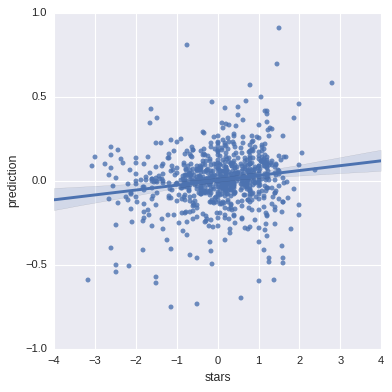

In [10]:
sns.lmplot(x='stars', y='prediction', data=pred_df)

In [6]:
user_id = np.random.choice(rec.all_users)
print(user_id)

TqbSA-djveQQOJ3n1o-GaQ


In [7]:
json.loads(rec.recommend(user_id, 3))

[{u'address': u'28 Easter Rd',
  u'categories': [u'Fast Food', u'Chinese', u'Restaurants'],
  u'name': u'Ricebox Take Away Food Shops',
  u'stars': 2.0},
 {u'address': u'8 Gloucester Street',
  u'categories': [u'Restaurants', u'Thai'],
  u'name': u'Songkran',
  u'stars': 4.0},
 {u'address': u'National Gallery Complex, The Mound',
  u'categories': [u'Breakfast & Brunch',
   u'Restaurants',
   u'Tea Rooms',
   u'Modern European',
   u'British',
   u'Coffee & Tea',
   u'Food'],
  u'name': u'Victor & Carina Contini The Scottish Cafe and Restaurant',
  u'stars': 4.0}]

In [8]:
json.loads(rec.list_ratings(user_id, 3))

[{u'address': u'9 Dundee Terrace',
  u'categories': [u'Indian', u'Restaurants'],
  u'name': u'Guru Balti Restaurant',
  u'stars': 4.5},
 {u'address': u'325 Leith Walk',
  u'categories': [u'Restaurants', u'Italian', u'Pizza'],
  u'name': u'La Favorita',
  u'stars': 4.5},
 {u'address': u'50 Potterow',
  u'categories': [u'Food',
   u'Imported Food',
   u'Restaurants',
   u'Pakistani',
   u'Specialty Food',
   u'Ethnic Food'],
  u'name': u'The Original Mosque Kitchen',
  u'stars': 4.0}]